# Data Mince
### Collating the datasets we always need for demographic context

#### Why 'data mince'?
A long time ago, my brother went off to university and started learning to shop, cook and stay alive on a student's budget. He found out that pretty quickly he fell into a pattern; after a long day of lectures and coursework and assignments he would realise it was time to cook dinner. He'd chop an onion and start frying it, add some cheap beef mince to the pan ... and then realise he hadn't decided what he was actually making. Chilli? Spag bol? Maybe go all out and make cottage pie? His basic fried-mince-and-onion was just the starting point.

What we found when we started working on projects for different clients, no matter how sophisticated the toolset or the problem, was that we almost always needed to start with the same initial collection of demographic data; population, income, deprivation, working patterns and so on. This is our 'data mince'.

#### The datasets

- population (NOMIS)
- income and work patterns (NOMIS)
- industries (NOMIS)
- working population (NOMIS)
- Indices of Multiple Deprivation (MHCLG)
- job types (LMIforAll)
- vacancies (LMIforAll)
- house prices (Land Registry) 
- places

### The python libraries we'll need
`requests` - for calling APIs that return json  
`pandas` - for calling APIs and urls that return CSVs and making them into dataframes  
`json` - for manipulating json files  
`matplotlib` - for making figures and charts  

In [175]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# what are we calling on?
stub = "http://api.lmiforall.org.uk/api/v1/soc/search?q="
qterm = "doctor"

url = stub + qterm

# A few sample calls
# http://api.lmiforall.org.uk/api/v1/soc/search?q=health
# http://api.lmiforall.org.uk/api/v1/soc/search?q=medical

# could create a list of relevant keywords here for health jobs and have the code iterate through to build a file
# need 'soc', 'title' and 'add titles' (list) for each call to build a reference file

r = requests.get(url)

In [296]:
# Checking our work
#print ("Status is %s" % r.status_code)
#print ("Encoding is %s" % r.encoding)
#print ("Response headers are %s" % r.headers)

In [297]:
jobsfile = json.loads(r.text)
#print(json.dumps(jobsfile, indent=4, sort_keys=True))

In [295]:
# Vacancies
# note location data is dirty, would need resolving if we want to do anything with it
# LMIforAll data is either by region (e.g. NE) or by single point/postcode and radius, default 50 miles
url = "http://api.lmiforall.org.uk/api/v1/vacancies/search?location=Devon%20&keywords=trainer"
r = requests.get(url)
vacsfile = json.loads(r.text)
#print(json.dumps(vacsfile, indent=4, sort_keys=True))

In [251]:
# IMD
url = "https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/845345/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv"
imd = pd.read_csv(url)
imd.columns = ['lsoa_code','lsoa_name','geography_code','geography_name','imd_score','imd_rank','imd_decile','income_score','income_rank','income_decile','employment_score','employment_rank','employment_decile','skills_score','skills_rank','skills_decile','health_score','health_rank','health_decile','crime_score','crime_rank','crime_decile','housing_score','housing_rank','housing_decile','living_env_score','living_env_rank','living_env_decile','idaci_score','idaci_rank','idaci_decile','idaopi_score','idaopi_rank','idaopi_decile','cyp_score','cyp_rank','cyp_decile','adult_skills_score','adult_skills_rank','adult_skills_decile','geobarriers_score','geobarriers_rank','geobarriers_decile','wider_barriers_score','wider_barriers_rank','wider_barriers_decile','indoors_score','indoors_rank','indoors_decile','outdoors_score','outdoors_rank','outdoors_decile','total_pop','pop0to15','pop16to59','pop60+','working_age']
#imd.head()

In [250]:
# filter for Devon geography
# snippet from tutorial gapminder_2002 = gapminder[gapminder['year']==2002]
# snippet 2 gapminder_years= gapminder[gapminder.year.isin(years)]
districts = ['East Devon','Exeter','Mid Devon','North Devon','Plymouth','South Hams','Teignbridge','Torbay','Torridge','West Devon']
imdDevon = imd[imd['geography_name'].isin(districts)]
#imdDevon.head()

In [249]:
# IMD pivot for chart
# snippet from docs DataFrame.pivot(self, index=None, columns=None, values=None)
# pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All')
imd_slice = imdDevon.pivot_table(index='geography_name', columns='imd_decile', values='geography_code', aggfunc='count',fill_value=0)
#imd_slice.head()

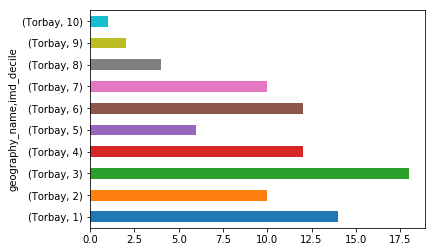

In [213]:
stacked = imd_slice[7:8].stack().plot(kind='barh')
#plt.show()

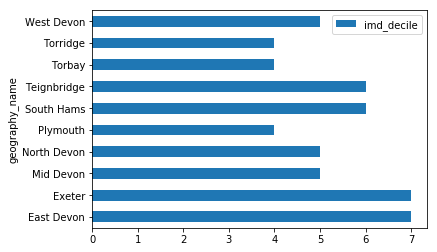

In [195]:
pivot = imdDevon.pivot_table(index=['geography_name'], values=['imd_decile'], aggfunc='median').plot(kind='barh')
#plt.show()

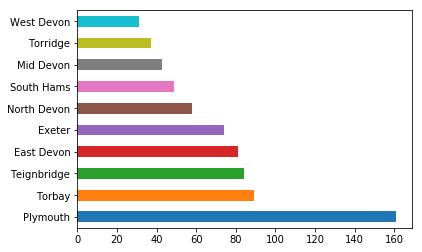

In [190]:
lsoas = imdDevon['geography_name'].value_counts().plot(kind='barh')
#plt.show()

In [248]:
# Population - 5 year bands
baseURL = "https://www.nomisweb.co.uk/api/v01/dataset/NM_2002_1.data.csv?"
url = baseURL + "geography=1820328235...1820328238,1820328230,1820328239,1820328240,1820328233,1820328241,1820328242&date=latest&gender=0&c_age=1,3...18,210&measures=20100"
#Projection
url+='&select=date_name,geography_name,geography_code,c_age_name,measures_name,obs_value,obs_status_name'
pop = pd.read_csv(url)
pop['C_AGE_NAME'] = pop['C_AGE_NAME'].replace(['Aged 5-9'], 'Aged 05-09') # tidies up display order in charts
#pop.head()

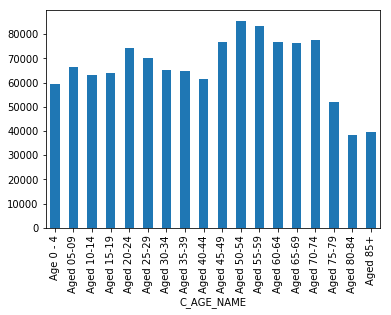

In [227]:
# Population chart
poppivot = pop.pivot_table(index=['C_AGE_NAME'], values=['OBS_VALUE'], aggfunc='sum').plot(kind='bar',legend=None)
plt.show()

In [246]:
# Income stats - gross weekly pay
baseURL='http://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.csv?'
url=baseURL+'geography=1967128584,1820328235...1820328238,1820328230,1820328239,1820328240,1820328233,1820328241,1820328242&date=latest&sex=5,6&item=2&pay=1&measures=20100'
#Projection
url+='&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value'
income=pd.read_csv(url)
#income.head()

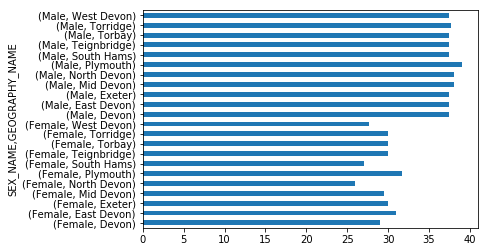

In [245]:
# Gross weekly pay chart
income_pivot = income.pivot_table(index=['SEX_NAME','GEOGRAPHY_NAME'], values=['OBS_VALUE'], aggfunc='sum').plot(kind='barh',legend=None)
plt.show()

In [247]:
# Income stats - hours worked
baseURL='http://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.csv?'
url=baseURL+'geography=1967128584,1820328235...1820328238,1820328230,1820328239,1820328240,1820328233,1820328241,1820328242&date=latest&sex=5,6&item=2&pay=9&measures=20100'
#Projection
url+='&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value'
hours=pd.read_csv(url)
#hours.head()

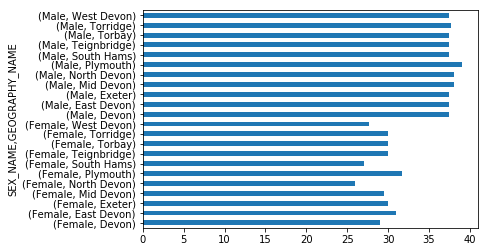

In [243]:
# Weekly hours worked chart
hours_pivot = hours.pivot_table(index=['SEX_NAME','GEOGRAPHY_NAME'], values=['OBS_VALUE'], aggfunc='sum').plot(kind='barh',legend=None)
plt.show()

In [260]:
# Workforce jobs
baseURL = "http://www.nomisweb.co.uk/api/v01/dataset/NM_130_1.data.csv?"
url = baseURL + "geography=2013265929&date=latest&industry=150994945...150994964&item=1,2,3&measures=20100"
#Projection
url += "&select=date_name,geography_name,geography_code,industry_name,item_name,measures_name,obs_value,obs_status_name"
jobs=pd.read_csv(url)
#jobs.head()

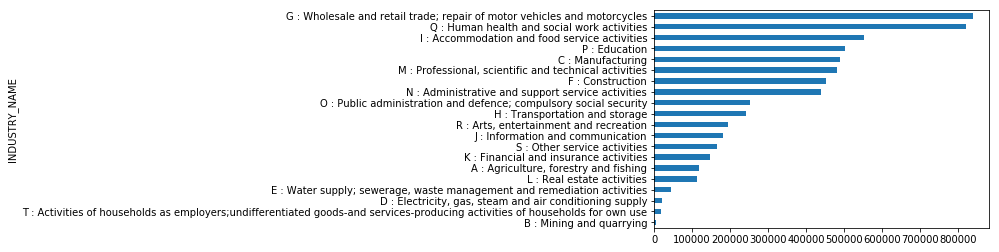

In [258]:
# Workforce jobs chart
jobs_pivot = jobs.pivot_table(index=['INDUSTRY_NAME'], values=['OBS_VALUE'], aggfunc='sum').sort_values('OBS_VALUE', ascending=True).plot(kind='barh',legend=None)
plt.show()

In [275]:
# Annual Labour Survey - economic activity rate
baseURL = "https://www.nomisweb.co.uk/api/v01/dataset/NM_17_5.data.csv?"
url = baseURL + "geography=1820328235...1820328238,1820328230,1820328239,1820328240,1820328233,1820328241,1820328242&date=latest&variable=18&measures=20599"
#Projection
url += "&select=date_name,geography_name,geography_code,variable_name,measures_name,obs_value"
active = pd.read_csv(url)
#employment.head()

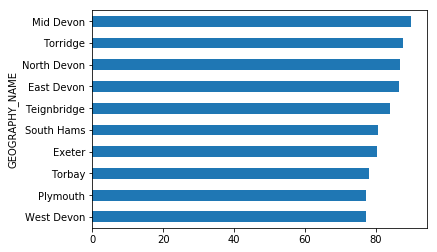

In [276]:
# Economic activity rate chart
active_pivot = active.pivot_table(index=['GEOGRAPHY_NAME'], values=['OBS_VALUE'], aggfunc='sum').sort_values('OBS_VALUE', ascending=True).plot(kind='barh',legend=None)
plt.show()

In [282]:
# Annual Labour Survey - employment rate
baseURL = "https://www.nomisweb.co.uk/api/v01/dataset/NM_17_5.data.csv?"
url = baseURL + "geography=1820328235...1820328238,1820328230,1820328239,1820328240,1820328233,1820328241,1820328242&date=latest&variable=45&measures=20599"
#Projection
url += "&select=date_name,geography_name,geography_code,variable_name,measures_name,obs_value"
employment = pd.read_csv(url)
#employment.head(20)

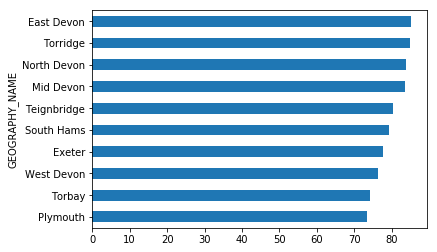

In [274]:
# Employment rate chart
emp_pivot = employment.pivot_table(index=['GEOGRAPHY_NAME'], values=['OBS_VALUE'], aggfunc='sum').sort_values('OBS_VALUE', ascending=True).plot(kind='barh',legend=None)
plt.show()

In [283]:
# Annual Labour Survey - % employed
baseURL = "https://www.nomisweb.co.uk/api/v01/dataset/NM_17_5.data.csv?"
url = baseURL + "geography=1820328235...1820328238,1820328230,1820328239,1820328240,1820328233,1820328241,1820328242&date=latest&variable=248&measures=20599"
#Projection
url += "&select=date_name,geography_name,geography_code,variable_name,measures_name,obs_value"
employed = pd.read_csv(url)
#employed.head(20)

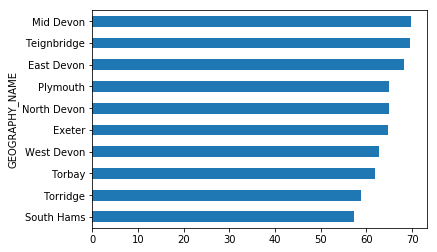

In [279]:
# % employed chart
empd_pivot = employed.pivot_table(index=['GEOGRAPHY_NAME'], values=['OBS_VALUE'], aggfunc='sum').sort_values('OBS_VALUE', ascending=True).plot(kind='barh',legend=None)
plt.show()

In [284]:
# Annual Labour Survey - % self employed
baseURL = "https://www.nomisweb.co.uk/api/v01/dataset/NM_17_5.data.csv?"
url = baseURL + "geography=1820328235...1820328238,1820328230,1820328239,1820328240,1820328233,1820328241,1820328242&date=latest&variable=249&measures=20599"
#Projection
url += "&select=date_name,geography_name,geography_code,variable_name,measures_name,obs_value"
selfemployed = pd.read_csv(url)
#selfemployed.head(20)

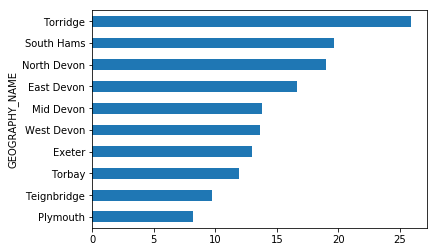

In [281]:
# % employed chart
sempd_pivot = selfemployed.pivot_table(index=['GEOGRAPHY_NAME'], values=['OBS_VALUE'], aggfunc='sum').sort_values('OBS_VALUE', ascending=True).plot(kind='barh',legend=None)
plt.show()

In [291]:
# Annual Labour Survey - employment by section
baseURL = "https://www.nomisweb.co.uk/api/v01/dataset/NM_17_5.data.csv?"
url = baseURL + "geography=1820328235...1820328238,1820328230,1820328239,1820328240,1820328233,1820328241,1820328242&date=latest&variable=1532...1540&measures=20599"
#Projection
url += "&select=date_name,geography_name,geography_code,variable_name,measures_name,obs_value"
section = pd.read_csv(url)
#section.head(20)

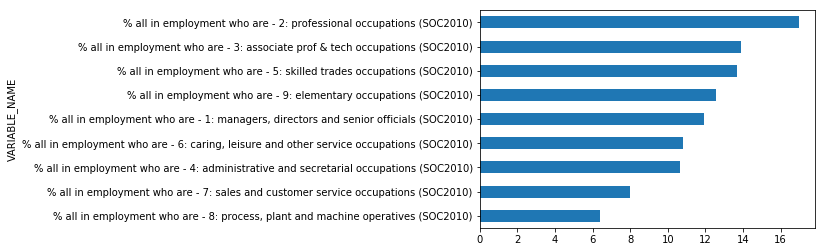

In [290]:
# Employment by section chart
section_pivot = section.pivot_table(index=['VARIABLE_NAME'], values=['OBS_VALUE'], aggfunc='median').sort_values('OBS_VALUE', ascending=True).plot(kind='barh',legend=None)
plt.show()

In [157]:
# House prices - year to date
ytd = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2019.csv"
hp = pd.read_csv(ytd)
hp.columns = ['uid','price','date','postcode','type','new','duration','paon','saon','street','locality','town','district','county','ppd','record']
#hp.fillna(" ")
hp.head()

,uid,price,date,postcode,type,new,duration,paon,saon,street,locality,town,district,county,ppd,record
0,{8355F009-BD6C-55C5-E053-6B04A8C0D090},396000,2019-01-31 00:00,SP8 4HB,O,N,F,DOLPHIN INN,NaN,PEACEMARSH,NaN,GILLINGHAM,NORTH DORSET,DORSET,B,A
1,{8355F009-BD6D-55C5-E053-6B04A8C0D090},197500,2019-01-11 00:00,SP8 4EQ,D,N,F,14,NaN,SYLVAN WAY,NaN,GILLINGHAM,NORTH DORSET,DORSET,B,A
2,{8355F009-BD6E-55C5-E053-6B04A8C0D090},230000,2019-01-28 00:00,BH4 9JY,F,N,L,"WHEATON GRANGE, 16",FLAT 6,BRANKSOME WOOD ROAD,NaN,BOURNEMOUTH,BOURNEMOUTH,BOURNEMOUTH,B,A
3,{8355F009-BD6F-55C5-E053-6B04A8C0D090},215500,2019-01-17 00:00,BH12 1AW,F,N,L,344,FLAT 1,POOLE ROAD,BRANKSOME,POOLE,POOLE,POOLE,B,A
4,{8355F009-BD70-55C5-E053-6B04A8C0D090},242000,2019-02-08 00:00,DT11 7FS,O,N,F,22,NaN,RIFLES WAY,NaN,BLANDFORD FORUM,NORTH DORSET,DORSET,B,A
